In [3]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import gym
import matplotlib.pyplot as plt 

from os import path
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

import matplotlib.pyplot as plt

DEFAULT_X = np.pi
DEFAULT_Y = 1.0

In [5]:
# Use GPU if available
device = T.device("cuda" if T.cuda.is_available() else "cpu")
print(device)

cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
class PendulumEnv(gym.Env):
    """
       ### Description

    The inverted pendulum swingup problem is based on the classic problem in control theory.
    The system consists of a pendulum attached at one end to a fixed point, and the other end being free.
    The pendulum starts in a random position and the goal is to apply torque on the free end to swing it
    into an upright position, with its center of gravity right above the fixed point.

    The diagram below specifies the coordinate system used for the implementation of the pendulum's
    dynamic equations.

    ![Pendulum Coordinate System](./diagrams/pendulum.png)

    -  `x-y`: cartesian coordinates of the pendulum's end in meters.
    - `theta` : angle in radians.
    - `tau`: torque in `N m`. Defined as positive _counter-clockwise_.

    ### Action Space

    The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum.

    | Num | Action | Min  | Max |
    |-----|--------|------|-----|
    | 0   | Torque | -2.0 | 2.0 |


    ### Observation Space

    The observation is a `ndarray` with shape `(3,)` representing the x-y coordinates of the pendulum's free
    end and its angular velocity.

    | Num | Observation      | Min  | Max |
    |-----|------------------|------|-----|
    | 0   | x = cos(theta)   | -1.0 | 1.0 |
    | 1   | y = sin(theta)   | -1.0 | 1.0 |
    | 2   | Angular Velocity | -8.0 | 8.0 |

    ### Rewards

    The reward function is defined as:

    *r = -(theta<sup>2</sup> + 0.1 * theta_dt<sup>2</sup> + 0.001 * torque<sup>2</sup>)*

    where `$\theta$` is the pendulum's angle normalized between *[-pi, pi]* (with 0 being in the upright position).
    Based on the above equation, the minimum reward that can be obtained is
    *-(pi<sup>2</sup> + 0.1 * 8<sup>2</sup> + 0.001 * 2<sup>2</sup>) = -16.2736044*,
    while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

    ### Starting State

    The starting state is a random angle in *[-pi, pi]* and a random angular velocity in *[-1,1]*.

    ### Episode Truncation

    The episode truncates at 200 time steps.

    ### Arguments

    - `g`: acceleration of gravity measured in *(m s<sup>-2</sup>)* used to calculate the pendulum dynamics.
      The default value is g = 10.0 .

    ```
    gym.make('Pendulum-v1', g=9.81)
    ```

    ### Version History

    * v1: Simplify the math equations, no difference in behavior.
    * v0: Initial versions release (1.0.0)

    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        self.max_speed = 8
        self.max_torque = 2.0
        self.dt = 0.05
        self.g = g
        self.m = 0.5
        self.l = 1.0
        self.b = 0.1

        self.render_mode = render_mode

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True

        high = np.array([1.0, 1.0, self.max_speed], dtype=np.float32)
        # This will throw a warning in tests/envs/test_envs in utils/env_checker.py as the space is not symmetric
        #   or normalised as max_torque == 2 by default. Ignoring the issue here as the default settings are too old
        #   to update to follow the openai gym api
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

    def angle_normalize(self, x):
      return ((x + np.pi) % (2 * np.pi)) - np.pi

    def step(self, u):
        th, thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        dt = self.dt

        u = np.clip(u, -self.max_torque, self.max_torque)
        self.last_u = u  # for rendering
        costs = self.angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)
        newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u - self.b*thdot/(m*l**2)) * dt

        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * dt

        self.state = np.array([newth, newthdot])

        if self.render_mode == "human":
            self.render()
        
        return self._get_obs(), -costs, False, False, {}

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        if options is None:
            high = np.array([DEFAULT_X, DEFAULT_Y])
        else:
            # Note that if you use custom reset bounds, it may lead to out-of-bound
            # state/observations.
            x = options.get("x_init") if "x_init" in options else DEFAULT_X
            y = options.get("y_init") if "y_init" in options else DEFAULT_Y
            x = utils.verify_number_and_cast(x)
            y = utils.verify_number_and_cast(y)
            high = np.array([x, y])
        low = -high  # We enforce symmetric limits.
        self.state = self.np_random.uniform(low=low, high=high)
        self.last_u = None

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([np.cos(theta), np.sin(theta), thetadot], dtype=np.float32)

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_dim, self.screen_dim)
                )
            else:  # mode in "rgb_array"
                self.screen = pygame.Surface((self.screen_dim, self.screen_dim))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((self.screen_dim, self.screen_dim))
        self.surf.fill((255, 255, 255))

        bound = 2.2
        scale = self.screen_dim / (bound * 2)
        offset = self.screen_dim // 2

        rod_length = 1 * scale
        rod_width = 0.2 * scale
        l, r, t, b = 0, rod_length, rod_width / 2, -rod_width / 2
        coords = [(l, b), (l, t), (r, t), (r, b)]
        transformed_coords = []
        for c in coords:
            c = pygame.math.Vector2(c).rotate_rad(self.state[0] + np.pi / 2)
            c = (c[0] + offset, c[1] + offset)
            transformed_coords.append(c)
        gfxdraw.aapolygon(self.surf, transformed_coords, (204, 77, 77))
        gfxdraw.filled_polygon(self.surf, transformed_coords, (204, 77, 77))

        gfxdraw.aacircle(self.surf, offset, offset, int(rod_width / 2), (204, 77, 77))
        gfxdraw.filled_circle(
            self.surf, offset, offset, int(rod_width / 2), (204, 77, 77)
        )

        rod_end = (rod_length, 0)
        rod_end = pygame.math.Vector2(rod_end).rotate_rad(self.state[0] + np.pi / 2)
        rod_end = (int(rod_end[0] + offset), int(rod_end[1] + offset))
        gfxdraw.aacircle(
            self.surf, rod_end[0], rod_end[1], int(rod_width / 2), (204, 77, 77)
        )
        gfxdraw.filled_circle(
            self.surf, rod_end[0], rod_end[1], int(rod_width / 2), (204, 77, 77)
        )

        fname = path.join(path.dirname(__file__), "assets/clockwise.png")
        img = pygame.image.load(fname)
        if self.last_u is not None:
            scale_img = pygame.transform.smoothscale(
                img,
                (scale * np.abs(self.last_u) / 2, scale * np.abs(self.last_u) / 2),
            )
            is_flip = bool(self.last_u > 0)
            scale_img = pygame.transform.flip(scale_img, is_flip, True)
            self.surf.blit(
                scale_img,
                (
                    offset - scale_img.get_rect().centerx,
                    offset - scale_img.get_rect().centery,
                ),
            )

        # drawing axle
        gfxdraw.aacircle(self.surf, offset, offset, int(0.05 * scale), (0, 0, 0))
        gfxdraw.filled_circle(self.surf, offset, offset, int(0.05 * scale), (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        else:  # mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


In [7]:
cObject = PendulumEnv()
cObject.reset()
cState, cReward, info, done, _ = cObject.step(1.0)
print(cState)

[0.4575676 0.8891748 1.5453244]


In [8]:
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
     
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        f3 = 0.003
        self.q = nn.Linear(self.fc2_dims, 1)
        T.nn.init.uniform_(self.q.weight.data, -f3, f3)
        T.nn.init.uniform_(self.q.bias.data, -f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)

        action_value = F.relu(self.action_value(action))
        state_action_value = F.relu(T.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value


class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        f3 = 0.003
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        T.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        T.nn.init.uniform_(self.mu.bias.data, -f3, f3)
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = T.tanh(self.mu(x))

        return x

class Agent(object):
    def __init__(self, alpha, beta, input_dims, tau, env, gamma=0.9,
                 n_actions=1, max_size=10000, layer1_size=30,
                 layer2_size=30, batch_size=32):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name='Actor')
        self.critic = CriticNetwork(beta, input_dims, layer1_size,
                                    layer2_size, n_actions=n_actions,
                                    name='Critic')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='TargetActor')
        self.target_critic = CriticNetwork(beta, input_dims, layer1_size,
                                           layer2_size, n_actions=n_actions,
                                           name='TargetCritic')

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        observation = T.tensor(observation, dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(observation).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(),
                                 dtype=T.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()


    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.critic.device)
        done = T.tensor(done).to(self.critic.device)
        new_state = T.tensor(new_state, dtype=T.float).to(self.critic.device)
        action = T.tensor(action, dtype=T.float).to(self.critic.device)
        state = T.tensor(state, dtype=T.float).to(self.critic.device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)

        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma*critic_value_[j]*done[j])
        target = T.tensor(target).to(self.critic.device)
        target = target.view(self.batch_size, 1)

        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.critic.eval()
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                      (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)


In [9]:
cObject = PendulumEnv()
cObject.reset()
cState, cReward, info, done, _ = cObject.step(1.0)
print(cState)

[-0.9493935   0.31408912 -0.3012493 ]


In [10]:
agent = Agent(alpha=0.001, beta=0.002, input_dims=[3], tau=0.01, env=cObject,
              batch_size=32,  layer1_size=30, layer2_size=30, n_actions=1)

#agent.load_models()
np.random.seed(0)

score_history = []
for i in range(200):
    obs = cObject.reset()
    obs = obs[0]
    done = False
    score = 0
    its = 500
    while not done and its>0:
        act = agent.choose_action(obs)
        new_state, reward, done, info, _ = cObject.step(act)
        new_state = new_state.ravel()
        reward = reward[0]
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state
        its-=1
        
    score_history.append(score)

    #if i % 25 == 0:
    #    agent.save_models()

    print('episode ', i, 'score', score)

episode  0 score -4282.056170940399
episode  1 score -3650.264048099518
episode  2 score -3615.1732712984085
episode  3 score -3175.0453731119633
episode  4 score -2563.1577920913696
episode  5 score -3562.843005180359
episode  6 score -1795.1539103612304
episode  7 score -2590.9736974835396
episode  8 score -1519.3670735359192
episode  9 score -1960.84163152799
episode  10 score -1713.1739936098456
episode  11 score -1308.5156827904284
episode  12 score -1261.6259933616966
episode  13 score -1182.214491294697
episode  14 score -1298.1936409510672
episode  15 score -1553.5089059108868
episode  16 score -1165.2629376403056
episode  17 score -530.0052580583192
episode  18 score -3760.1560039520264
episode  19 score -3610.087327003479
episode  20 score -410.1756983981468
episode  21 score -785.433985711541
episode  22 score -664.18362573185
episode  23 score -666.1084137093276
episode  24 score -1036.752879427513
episode  25 score -651.0001495354809
episode  26 score -381.7479487180244
ep

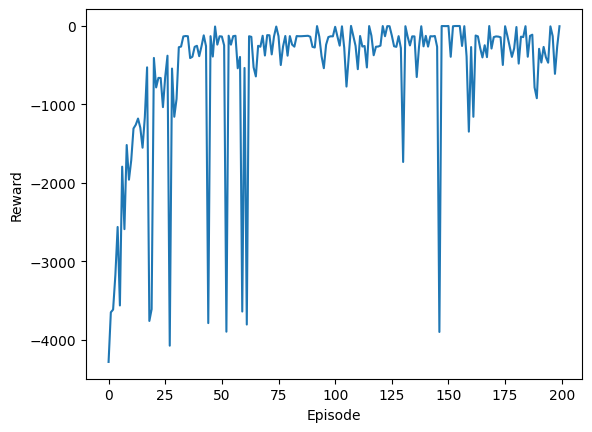

In [11]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(score_history)), score_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()